## 01. Preliminary simulation of spectra for 10 stars using Slitless-Spectroscopy

This notebook uses the spectral library [Phoenix](http://phoenix.astro.physik.uni-goettingen.de/) to study the synthetic spectra from stars of different spectra types. Ten stars of different effective temperature $T_e$ and surface gravity $g$ are chosen, and their spectra is plotted. Furthermore, this notebook attempts to recover the spectral image one would obtain when observing these stars in the slitless spectroscopy mode.

The notebook is divided into the following sections:

1. Defining the input parameters
2. Spectral parameters
3. Opening and reading the file
4. Plotting the spectra
5. Forming a spectral image

Script written by: **Soumya Shreeram** <br/> 
Project supervised by: **Nadine and Paco (MPIA)** <br/>
Date: **18th September 2020** <br/>

In [3]:
import astropy.io.fits as fits
from scipy.sparse import csr_matrix

import numpy as np
import os

# generate random integer values
from random import seed
from random import randint

# plotting imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm

import matplotlib
%matplotlib inline
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

In [2]:
import Simulating_Spectra as ss

#### 1. Defining the input parameters

In [4]:
# array containing the wavelength values for all the spectra
wave_filename = 'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'

# setting up the working directory path
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "Data")

# number of stars and generating their random positions
num_stars = 10
l_pix, u_pix = 0, 10000
x_pos = ss.generateRandInt(l_pix, u_pix, num_stars) 
y_pos = ss.generateRandInt(l_pix, u_pix, num_stars)

# corresponsing resolution
r = 1000

# TODO: find realistic conversion
wave_to_pixel = 500  # 0.1 micro meter == wave_to_pixel (pixels)
disperse_range = 1000 # this range == 0.5 micro m
dispersion_angle = 0 # degrees

# number of spectra
num_spectra = num_stars

# parameters considered :: [t_eff, log_g, Fe_H, alpha, spectral_types]
num_params = 5

# wavelength range for k-band
k_upper, k_lower = 2.4e4, 2.1e4

#### 2. Spectral parameters

In [6]:
# [K] effective temperature
t_eff_arr = [12000, 11800, 10000, 8400, 7600, 6900, 5900, 5100, 4700, 3900]    

# log of [cm/s^2] log (surface gravity) 
log_g_arr = [6.00, 2.50, 3.00, 6.00, 3.50, 3.00, 3.00, 2.00, 1.50, 6.00]    

# [M/H] metallicity
Fe_H = 0.0      

# [a/M] alpha element enhancement
alpha = 0       

spectral_type = ss.defineSpectralType(HiRes=True, MedRes=False)

#### 3. Opening and reading the file

The following code blocks puts together the fluxes and wavelegnths for all the chosen spectra into a 2D array.

In [8]:
_, len_wavelen = ss.extractWavelen(data_dir, wave_filename)
wave_len_arr2D, flux_arr2D = np.empty((0, len_wavelen)), np.empty((0, len_wavelen))
params_arr2D = np.empty((0, num_params)) 

for i in range(num_spectra):
  # choose the t_eff and log_g
  t_eff, log_g = t_eff_arr[i], log_g_arr[i]
  params = [t_eff, log_g, Fe_H, alpha, spectral_type]
  
  # read out the wavelength and flux for given set of parameters
  wave_len, flux = ss.readFile(data_dir, wave_filename, params)
  
  # add the wavelength and flux values to the 2D arrays
  wave_len_arr2D = np.append(wave_len_arr2D, [wave_len], axis=0)
  flux_arr2D = np.append(flux_arr2D, [flux], axis=0)
  params_arr2D = np.append(params_arr2D, [params], axis=0)

#### 4. Plotting the spectra

12000
11800
10000
8400
7600
6900
5900
5100
4700
3900


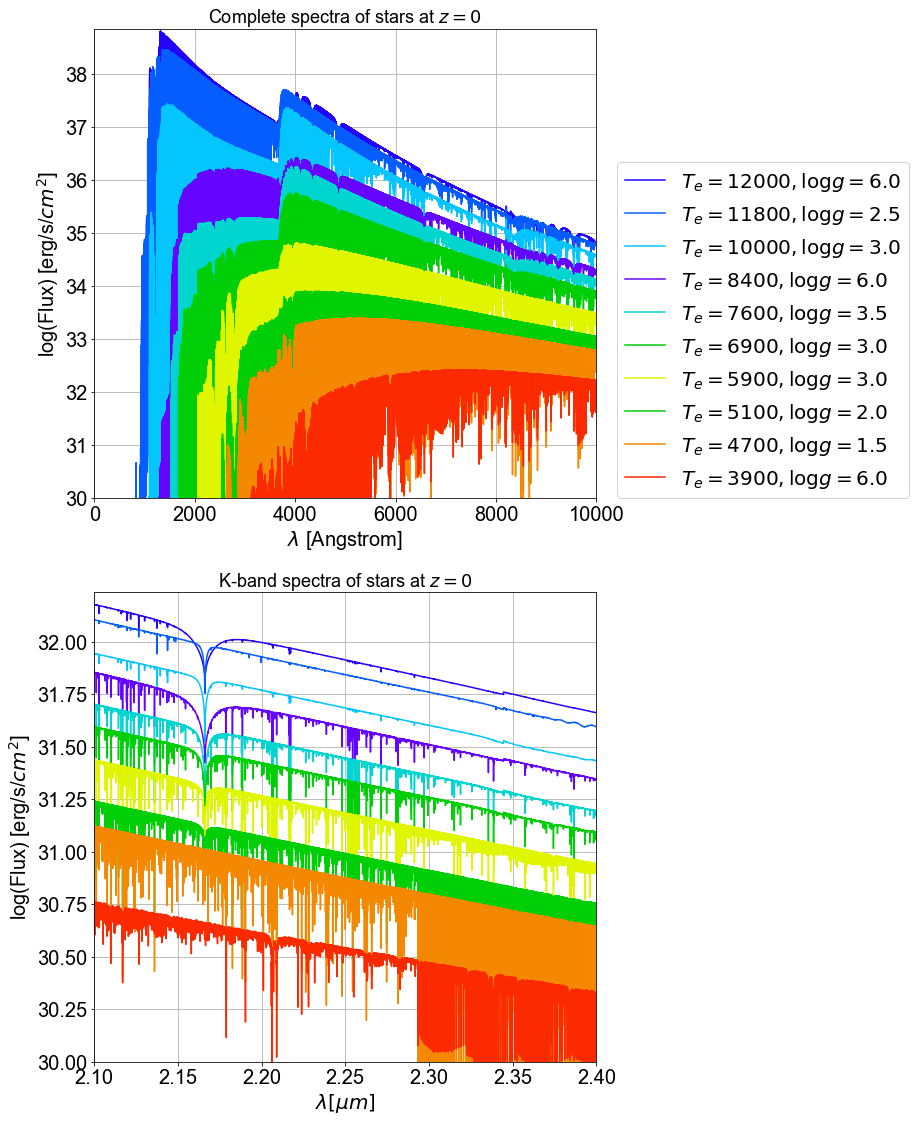

In [14]:
fig,ax = plt.subplots(2,1,figsize=(9,19))
colors = ['#2403fc', '#055dff', '#05c5ff', '#6505ff', '#02d4d0', '#00cf07', '#e0f500', '#00cf07', '#f58802', '#fc2a00']

for i in range(num_spectra):
  # complete spectra
  ax[0].plot(wave_len_arr2D[i], np.log(flux_arr2D[i]), color=colors[i], label=ss.labelSpectra(params_arr2D[i]));
  ss.setLabel(ax[0], r'$\lambda$ [Angstrom]', r'log(Flux) [erg/s/$cm^2$]', r'Complete spectra of stars at $z=0$', [0, 1e4], [30, np.log(7.5e16)], legend=True)

  # k-band spectra (flux is log)
  ax[1].plot(wave_len_arr2D[i]/10000, np.log(flux_arr2D[i]), color=colors[i])
  ss.setLabel(ax[1], r'$\lambda [\mu m]$', r'log(Flux) [erg/s/$cm^2$]', r'K-band spectra of stars at $z=0$', [2.1, 2.4], [30, np.log(1e14)], legend=False)

#### 5. Forming a spectral image

We chose dispersions only in the K-band wavelengths for the stars. 

In [11]:
# chosing the K-band wavelength
waves_k, idx = ss.chooseKband(wave_len_arr2D, k_upper, k_lower)

# defining the K-band flux
flux_k2D = np.empty((0, len(waves_k)))
flux_k2D = ss.fluxKband(flux_arr2D, x_pos, flux_k2D, idx)

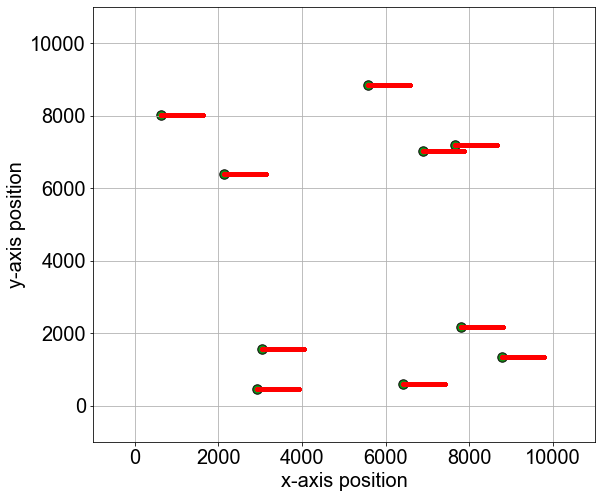

In [12]:
fig, ax = plt.subplots(1,1,figsize=(9,8))

# plotting the stars
ax.scatter(x_pos, y_pos, s=90, c="g", alpha=0.9, marker="o", edgecolors='k')
ss.setLabel(ax, 'x-axis position', 'y-axis position', '', [l_pix-disperse_range, u_pix+disperse_range], [l_pix-disperse_range, u_pix+disperse_range], legend=False)

# dispersing them in the k-band
x_disperse, y_disperse = ss.disperseStars(x_pos, y_pos, disperse_range, waves_k, ax, dispersion_angle)

Producing a contour plot by adding the flux

In [13]:
flux_matrix2D = np.empty((u_pix+disperse_range, u_pix+disperse_range))
  
for i in range(len(x_pos)):
  row = y_disperse[i]
  col = x_disperse[i] 
  data = flux_k2D[i]/np.max(flux_k2D[i])

  # csr_matrix from scipy puts together a 2D matrix with the desired info
  temp = csr_matrix((data, (row, col)), shape=(u_pix+disperse_range, u_pix+disperse_range)).toarray()

  # add all the contributions from all the stars
  flux_matrix2D = flux_matrix2D + temp

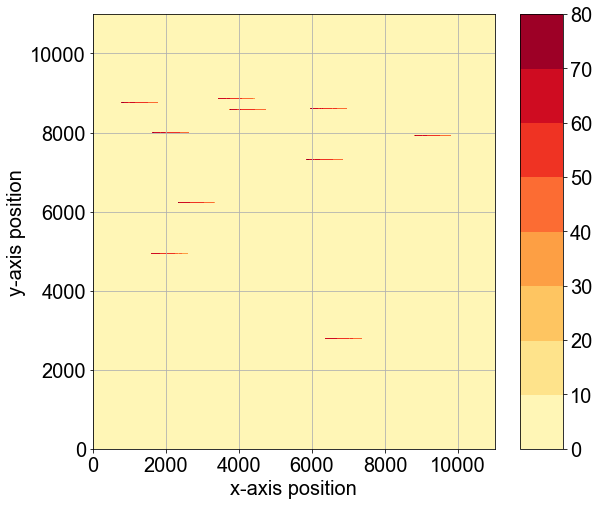

In [18]:
fig, ax = plt.subplots(1,1,figsize=(9,8))

X, Y = np.meshgrid(np.linspace(0, u_pix+disperse_range, u_pix+disperse_range), np.linspace(0, u_pix+disperse_range, u_pix+disperse_range))
plot = ax.contourf(X, Y, flux_matrix2D, cmap='YlOrRd')

# labeling and setting colorbar
setLabel(ax, 'x-axis position', 'y-axis position', '', [l_pix, u_pix+disperse_range], [l_pix, u_pix+disperse_range], legend=False)
cbar = plt.colorbar(plot, aspect=10);

#### 6. Adding the point spread and line spread function